In [2]:
import cv2
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
import tqdm as tqdm


from PIL import Image


In [ ]:
#++++++++++++++++++LOAD DATASET+++++++++++++++++++++++

In [4]:
path='pocus_videos/convex/'
annotation_path = "dataset_metadata.csv"
videos_list = os.listdir(path)

In [5]:
columns = ['Filename', 'Effusion', 'Consolidations', 'B-lines', 'A-lines', 'Pleural_line_irregularities', 'Air_bronchogram', 'Label']
base = pd.read_csv(annotation_path, usecols=columns)

In [6]:
base = base[base['Effusion'] != 'n/A']
base = base[base['Consolidations'] != 'n/A']
base = base[base['B-lines'] != 'n/A']
base = base[base['A-lines']  != 'n/A']
base = base[base['Pleural_line_irregularities']  != 'n/A']
base = base[base['Air_bronchogram']  != 'n/A']
base = base[base['Label']  != 'n/A']
#base = base[base['Label']  != 'regular']
#base = base[base['Label']  != 'Regular']
base['Label']= base['Label'].replace(['regular'], 'Regular')

base['Effusion'] = pd.to_numeric(base['Effusion'])
base.head()

,Filename,Label,Effusion,Consolidations,B-lines,A-lines,Pleural_line_irregularities,Air_bronchogram
0,Cov-Butterfly-COVID Lung 2,COVID-19,1.0,0.0,1.0,0.0,1.0,0.0
1,Cov-Butterfly-Skip Lesion,COVID-19,0.0,1.0,1.0,1.0,1.0,0.0
2,Cov-Butterfly-Confluent B lines,COVID-19,0.0,0.0,1.0,0.0,0.0,0.0
3,Reg-Butterfly-Normal Lung A lines,Regular,0.0,0.0,0.0,1.0,0.0,0.0
4,Reg-Butterfly-Normal Lung_Example 2,Regular,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
base  = base.dropna(axis = 0)
base.shape

(346, 8)

In [8]:
metadata = base;
metadata['Filename']

0               Cov-Butterfly-COVID Lung 2
1                Cov-Butterfly-Skip Lesion
2          Cov-Butterfly-Confluent B lines
3        Reg-Butterfly-Normal Lung A lines
4      Reg-Butterfly-Normal Lung_Example 2
                      ...                 
344                Cov-B_ConvexProb_score1
345               Cov-C_Convex_Prob_score2
346               Cov-D_Convex_Prob_score3
347                Cov-C_ConvexProb_score3
348                    Cov-MSU-SkipLesions
Name: Filename, Length: 346, dtype: object

In [7]:
#"Cov-Butterfly-COVID Lung 2" in metadata['Filename']
teste = metadata.loc[metadata.Filename == "Reg-Atlas-lungcurtain"]
len(teste)

1

In [8]:
teste['B-lines']

26    0.0
Name: B-lines, dtype: float64

In [9]:
num_imgs_per_video = 10
#print(filename.split('.')[0])
X_train, y_train = [], []


In [12]:
#a = metadata.loc[metadata.Filename == filename.split('.')[0]]
#metadata['Filename'][a.index[0]]

In [72]:
def create_mydataset():
    X_train, y_train = [], []
    for filename in videos_list:
        count=0
        #print(filename)
        vid_cap = cv2.VideoCapture(path+'/'+filename)
        total_frame_count= int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = total_frame_count/num_imgs_per_video
        success, image = vid_cap.read()
        metadata_cap = metadata.loc[metadata.Filename == filename.split('.')[0]]
        if len(metadata_cap) >0:
            while success:
                #print("Reading new frame...", success)
                if ((count+1) % int(step) == 0):
                    #print("Writing new frame...")
                    out = 'dataset/{}_{}.png'.format(filename.split('.')[0], count)
                    img = tf.keras.utils.load_img(out, target_size = (224, 224, 3))
                    img = tf.keras.utils.img_to_array(img)
                    img= img/255.
                    #img = img.transpose(2,0,1)
                    #cv2.imwrite(out, image)
                    X_train.append(img)
                    y_train.append([metadata['B-lines'][metadata_cap.index[0]]])
                                     #metadata['Consolidations'][metadata_cap.index[0]],
                                     #metadata['B-lines'][metadata_cap.index[0]],
                                     #metadata['A-lines'][metadata_cap.index[0]],
                                     #metadata['Pleural_line_irregularities'][metadata_cap.index[0]],
                                     #metadata['Air_bronchogram'][metadata_cap.index[0]]])
                success, image = vid_cap.read()
                count += 1
        X = np.array(X_train)
        y = np.array(y_train)
        return X, y

In [73]:
create_mydataset()

In [17]:
#dataset = data.TensorDataset(torch.Tensor(X),torch.Tensor(y))

In [18]:
#dataset[0]

In [70]:
X

array(['dataset/Cov-Atlas+(44)_3.png', 'dataset/Cov-Atlas+(44)_7.png',
       'dataset/Cov-Atlas+(44)_11.png', ...,
       'dataset/Vir_whitelung_h1n1_95.png',
       'dataset/Vir_whitelung_h1n1_107.png',
       'dataset/Vir_whitelung_h1n1_119.png'], dtype='<U57')

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.2)

In [12]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model

In [36]:
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [11]:
BATCH_SIZE = 32 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically to reduce GPU and CPU idle time
SHUFFLE_BUFFER_SIZE = 1597 # Shuffle the training data by a chunck of 1024 observations

In [38]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [77]:
len(X_train)*0.8

980.0

In [40]:
train_ds = create_dataset(X_train[:980], y_train[:980])
val_ds = create_dataset(X_train[980:], y_train[980:])

In [13]:
import tensorflow_hub as hub
from tensorflow.keras import layers
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

In [14]:
feature_extractor_layer.trainable = True

In [43]:
N_LABELS = 1
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 hidden_layer (Dense)        (None, 1024)              1311744   
                                                                 
 output (Dense)              (None, 1)                 1025      
                                                                 
Total params: 3,570,753
Trainable params: 3,536,641
Non-trainable params: 34,112
_________________________________________________________________


In [45]:

def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [46]:
LR = 0.0001 # Keep it small when transfer learning
EPOCHS = 30

In [78]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss='binary_crossentropy',
  metrics=['accuracy'])

In [ ]:
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost.
    Average (1 - soft-F1) across all labels.
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    
    return macro_cost

In [79]:
X_train.shape

(1225, 224, 224, 3)

In [80]:
history = model.fit(X_train, y_train,
  epochs=EPOCHS,
  batch_size=64,
  validation_data=(X_test, y_test))

Epoch 1/30
20/20 [==============================] - 62s 3s/step - loss: 0.6269 - accuracy: 0.7502 - val_loss: 0.5886 - val_accuracy: 0.7850
Epoch 2/30
20/20 [==============================] - 55s 3s/step - loss: 0.4812 - accuracy: 0.8073 - val_loss: 0.5577 - val_accuracy: 0.7850
Epoch 3/30
20/20 [==============================] - 58s 3s/step - loss: 0.3934 - accuracy: 0.8686 - val_loss: 0.5240 - val_accuracy: 0.7915
Epoch 4/30
20/20 [==============================] - 59s 3s/step - loss: 0.3370 - accuracy: 0.9192 - val_loss: 0.4869 - val_accuracy: 0.7915
Epoch 5/30
20/20 [==============================] - 57s 3s/step - loss: 0.2913 - accuracy: 0.9298 - val_loss: 0.4501 - val_accuracy: 0.8208
Epoch 6/30
20/20 [==============================] - 58s 3s/step - loss: 0.2509 - accuracy: 0.9518 - val_loss: 0.4224 - val_accuracy: 0.8567
Epoch 7/30
20/20 [==============================] - 61s 3s/step - loss: 0.2249 - accuracy: 0.9739 - val_loss: 0.3927 - val_accuracy: 0.8697
Epoch 8/30
20/20 [==

In [22]:
def plot_curves(history):
    plt.figure(figsize=(5, 3))
    epochs = range(1, len(history.history['loss'])+1)
    plt.plot(epochs, history.history['loss'], label="Train loss")
    plt.plot(epochs, history.history['val_loss'], label="Test Loss")
    plt.title("Training Loss Curve")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend();
    
    plt.figure(figsize=(5, 3))
    epochs = range(1, len(history.history['accuracy'])+1)
    plt.plot(epochs, history.history['accuracy'], label="Train Acc")
    plt.plot(epochs, history.history['val_accuracy'], label="Test Acc")
    plt.title("Training Accuracy Curve")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

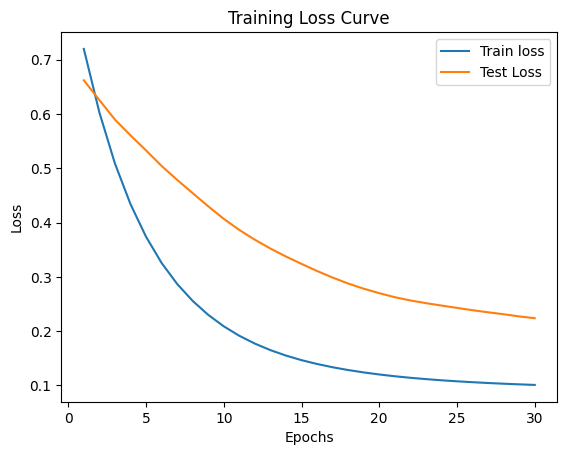

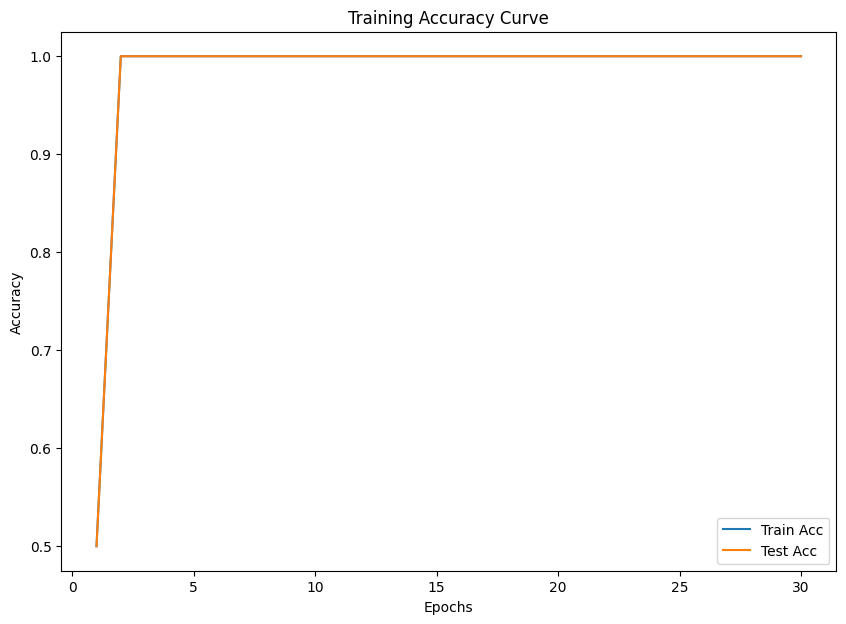

In [102]:
plot_curves(history)

In [83]:
filename = 'dataset\Pneu_northumbria_0409_set3_vid2_71.png'
img_teste = tf.keras.utils.load_img(filename, target_size = (224, 224, 3))
img_teste = tf.keras.utils.img_to_array(img_teste)
img_teste= img_teste/255.

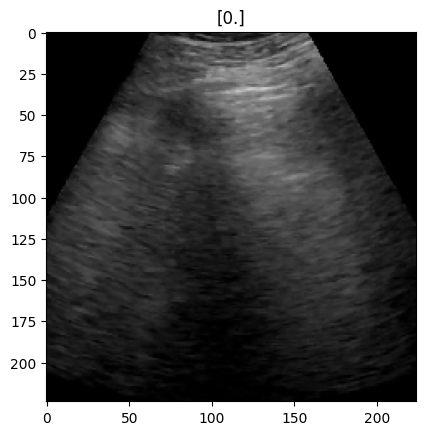

In [85]:
teste = X_test[1]
teste
plt.imshow(teste)
plt.title(str(y_test[1]));

In [86]:
np.expand_dims(teste,0).shape
preds = model.predict(np.expand_dims(teste,0))
preds, y_test[1]

1/1 [==============================] - 0s 375ms/step


(array([[0.02843018]], dtype=float32), array([0.]))

In [87]:
_, acc = model.evaluate(X_test,y_test)

10/10 [==============================] - 2s 221ms/step - loss: 0.0989 - accuracy: 0.9935


 # Binary: Effusion

In [109]:
metadata['Effusion'].value_counts()

0.0    307
1.0     39
Name: Effusion, dtype: int64

In [110]:
def create_mydataset_eff():
    X_train, y_train = [], []
    for filename in videos_list:
        count=0
        #print(filename)
        vid_cap = cv2.VideoCapture(path+'/'+filename)
        total_frame_count= int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = total_frame_count/num_imgs_per_video
        success, image = vid_cap.read()
        metadata_cap = metadata.loc[metadata.Filename == filename.split('.')[0]]
        if len(metadata_cap) >0:
            while success:
                #print("Reading new frame...", success)
                if ((count+1) % int(step) == 0):
                    #print("Writing new frame...")
                    out = 'dataset/{}_{}.png'.format(filename.split('.')[0], count)
                    img = tf.keras.utils.load_img(out, target_size = (224, 224, 3))
                    img = tf.keras.utils.img_to_array(img)
                    img= img/255.
                    #img = img.transpose(2,0,1)
                    #cv2.imwrite(out, image)
                    X_train.append(img)
                    y_train.append([metadata['Effusion'][metadata_cap.index[0]]])
                                     #metadata['Consolidations'][metadata_cap.index[0]],
                                     #metadata['B-lines'][metadata_cap.index[0]],
                                     #metadata['A-lines'][metadata_cap.index[0]],
                                     #metadata['Pleural_line_irregularities'][metadata_cap.index[0]],
                                     #metadata['Air_bronchogram'][metadata_cap.index[0]]])
                success, image = vid_cap.read()
                count += 1
    X = np.array(X_train)
    y = np.array(y_train)
    return X, y

In [111]:
X, y = create_mydataset_eff()
len(X)

1532

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.2)
X_train.shape

(1225, 224, 224, 3)

In [113]:
N_LABELS = 1
model_eff = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])
model_eff.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss='binary_crossentropy',
  metrics=['accuracy'])
history_eff = model_eff.fit(X_train, y_train,
  epochs=EPOCHS,
  batch_size=64,
  validation_data=(X_test, y_test))

Epoch 1/30
20/20 [==============================] - 63s 3s/step - loss: 0.5202 - accuracy: 0.8465 - val_loss: 0.4938 - val_accuracy: 0.8339
Epoch 2/30
20/20 [==============================] - 56s 3s/step - loss: 0.3653 - accuracy: 0.8784 - val_loss: 0.4482 - val_accuracy: 0.8339
Epoch 3/30
20/20 [==============================] - 56s 3s/step - loss: 0.3107 - accuracy: 0.8816 - val_loss: 0.4035 - val_accuracy: 0.8371
Epoch 4/30
20/20 [==============================] - 56s 3s/step - loss: 0.2643 - accuracy: 0.9151 - val_loss: 0.3605 - val_accuracy: 0.8436
Epoch 5/30
20/20 [==============================] - 56s 3s/step - loss: 0.2348 - accuracy: 0.9469 - val_loss: 0.3250 - val_accuracy: 0.8534
Epoch 6/30
20/20 [==============================] - 57s 3s/step - loss: 0.2068 - accuracy: 0.9706 - val_loss: 0.2909 - val_accuracy: 0.8893
Epoch 7/30
20/20 [==============================] - 56s 3s/step - loss: 0.1884 - accuracy: 0.9763 - val_loss: 0.2667 - val_accuracy: 0.8990
Epoch 8/30
20/20 [==

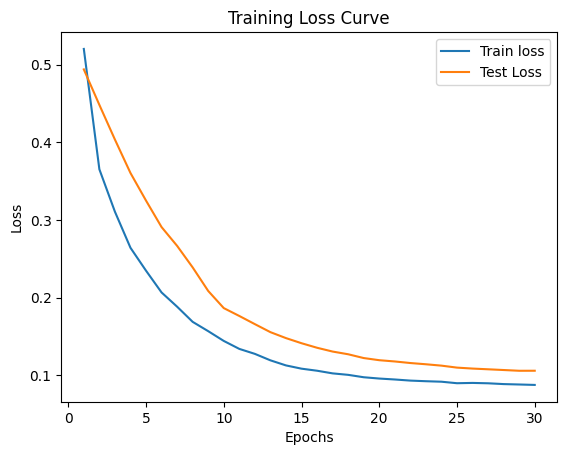

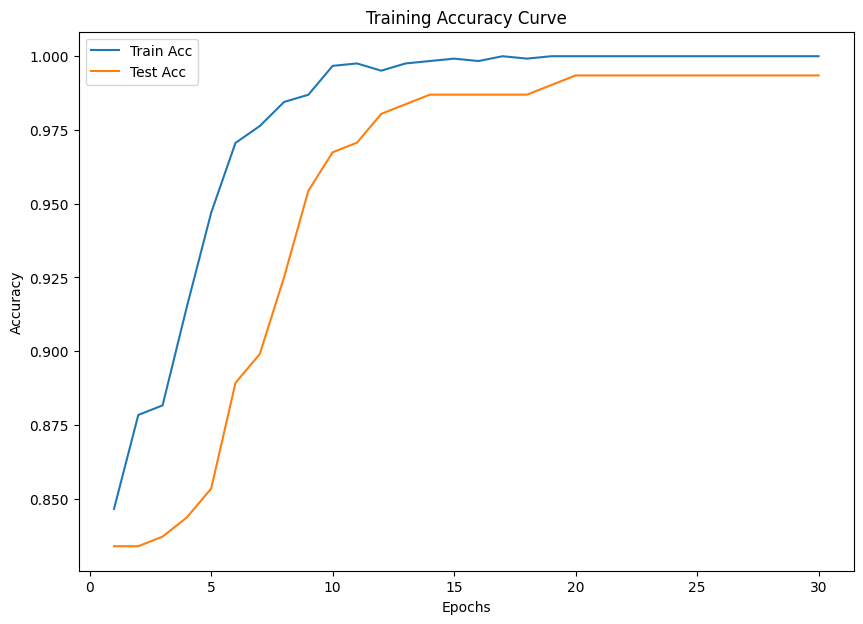

In [114]:
plot_curves(history_eff)

1/1 [==============================] - 0s 350ms/step


(array([[0.00506674]], dtype=float32), array([0.]))

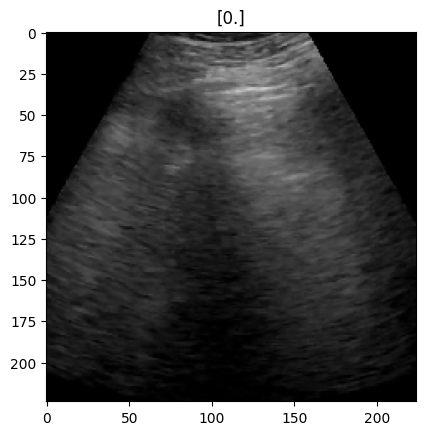

In [126]:
teste = X_test[1]
teste
plt.imshow(teste)
plt.title(str(y_test[1]));

np.expand_dims(teste,0).shape
preds = model_eff.predict(np.expand_dims(teste,0))
preds, y_test[1]

 # Binary: Consolidations

In [117]:
metadata['Consolidations'].value_counts()

0.0    260
1.0     86
Name: Consolidations, dtype: int64

In [120]:
def create_mydataset_con():
    X_train, y_train = [], []
    for filename in videos_list:
        count=0
        #print(filename)
        vid_cap = cv2.VideoCapture(path+'/'+filename)
        total_frame_count= int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = total_frame_count/num_imgs_per_video
        success, image = vid_cap.read()
        metadata_cap = metadata.loc[metadata.Filename == filename.split('.')[0]]
        if len(metadata_cap) >0:
            while success:
                #print("Reading new frame...", success)
                if ((count+1) % int(step) == 0):
                    #print("Writing new frame...")
                    out = 'dataset/{}_{}.png'.format(filename.split('.')[0], count)
                    img = tf.keras.utils.load_img(out, target_size = (224, 224, 3))
                    img = tf.keras.utils.img_to_array(img)
                    img= img/255.
                    #img = img.transpose(2,0,1)
                    #cv2.imwrite(out, image)
                    X_train.append(img)
                    y_train.append([metadata['Consolidations'][metadata_cap.index[0]]])
                                     #metadata['Consolidations'][metadata_cap.index[0]],
                                     #metadata['B-lines'][metadata_cap.index[0]],
                                     #metadata['A-lines'][metadata_cap.index[0]],
                                     #metadata['Pleural_line_irregularities'][metadata_cap.index[0]],
                                     #metadata['Air_bronchogram'][metadata_cap.index[0]]])
                success, image = vid_cap.read()
                count += 1
    X = np.array(X_train)
    y = np.array(y_train)
    return X, y

In [121]:
X, y = create_mydataset_con()
len(X)

1532

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.2)
X_train.shape

(1225, 224, 224, 3)

In [123]:
N_LABELS = 1
EPOCHS = 20
model_con = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])
model_con.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss='binary_crossentropy',
  metrics=['accuracy'])
history_con = model_con.fit(X_train, y_train,
  epochs=EPOCHS,
  batch_size=64,
  validation_data=(X_test, y_test))

Epoch 1/20
20/20 [==============================] - 79s 4s/step - loss: 0.7054 - accuracy: 0.6400 - val_loss: 0.5905 - val_accuracy: 0.7329
Epoch 2/20
20/20 [==============================] - 71s 4s/step - loss: 0.4952 - accuracy: 0.8441 - val_loss: 0.4544 - val_accuracy: 0.8567
Epoch 3/20
20/20 [==============================] - 71s 4s/step - loss: 0.3926 - accuracy: 0.9176 - val_loss: 0.3716 - val_accuracy: 0.9349
Epoch 4/20
20/20 [==============================] - 71s 4s/step - loss: 0.3276 - accuracy: 0.9486 - val_loss: 0.3167 - val_accuracy: 0.9544
Epoch 5/20
20/20 [==============================] - 68s 3s/step - loss: 0.2729 - accuracy: 0.9673 - val_loss: 0.2697 - val_accuracy: 0.9707
Epoch 6/20
20/20 [==============================] - 68s 3s/step - loss: 0.2428 - accuracy: 0.9714 - val_loss: 0.2352 - val_accuracy: 0.9805
Epoch 7/20
20/20 [==============================] - 68s 3s/step - loss: 0.2068 - accuracy: 0.9837 - val_loss: 0.2105 - val_accuracy: 0.9870
Epoch 8/20
20/20 [==

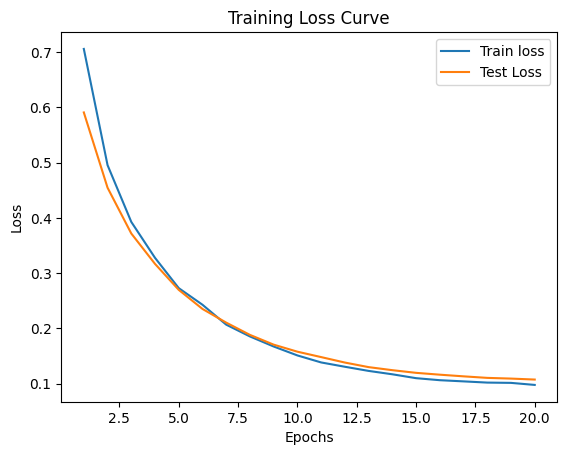

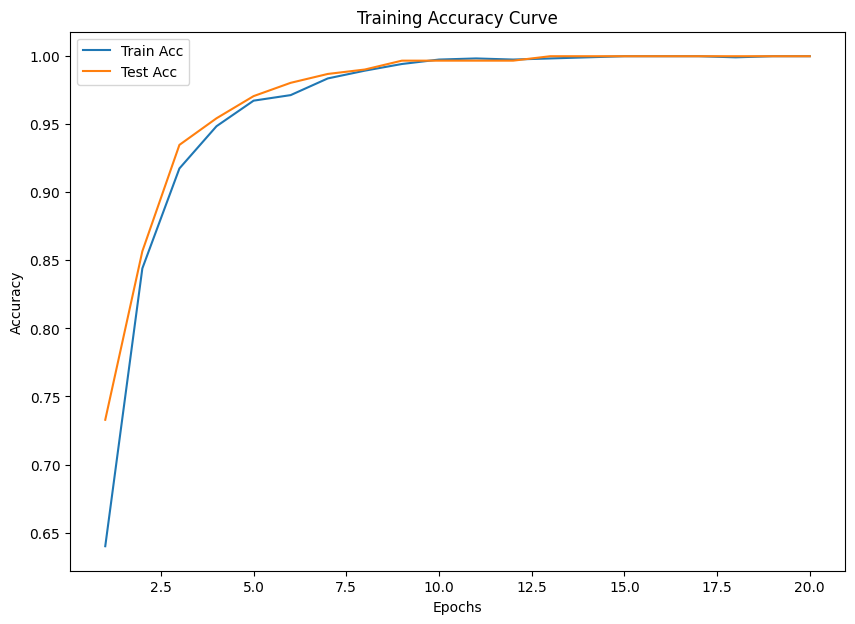

In [124]:
plot_curves(history_con)

1/1 [==============================] - 0s 57ms/step


(array([[0.00649491]], dtype=float32), array([0.]))

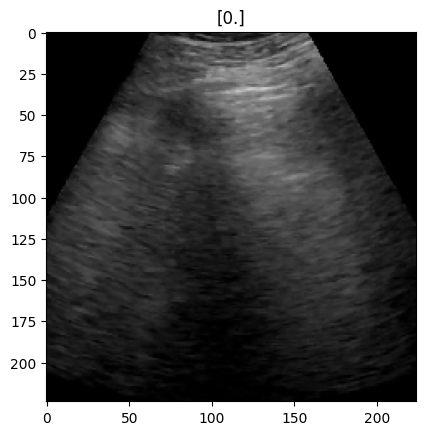

In [125]:
teste = X_test[1]
teste
plt.imshow(teste)
plt.title(str(y_test[1]));

np.expand_dims(teste,0).shape
preds = model_con.predict(np.expand_dims(teste,0))
preds, y_test[1]

 # Binary: Aline

In [128]:
metadata['A-lines'].value_counts()

0.0    312
1.0     34
Name: A-lines, dtype: int64

In [127]:
def create_mydataset_ali():
    X_train, y_train = [], []
    for filename in videos_list:
        count=0
        #print(filename)
        vid_cap = cv2.VideoCapture(path+'/'+filename)
        total_frame_count= int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = total_frame_count/num_imgs_per_video
        success, image = vid_cap.read()
        metadata_cap = metadata.loc[metadata.Filename == filename.split('.')[0]]
        if len(metadata_cap) >0:
            while success:
                #print("Reading new frame...", success)
                if ((count+1) % int(step) == 0):
                    #print("Writing new frame...")
                    out = 'dataset/{}_{}.png'.format(filename.split('.')[0], count)
                    img = tf.keras.utils.load_img(out, target_size = (224, 224, 3))
                    img = tf.keras.utils.img_to_array(img)
                    img= img/255.
                    #img = img.transpose(2,0,1)
                    #cv2.imwrite(out, image)
                    X_train.append(img)
                    y_train.append([metadata['A-lines'][metadata_cap.index[0]]])
                                     #metadata['Consolidations'][metadata_cap.index[0]],
                                     #metadata['B-lines'][metadata_cap.index[0]],
                                     #metadata['A-lines'][metadata_cap.index[0]],
                                     #metadata['Pleural_line_irregularities'][metadata_cap.index[0]],
                                     #metadata['Air_bronchogram'][metadata_cap.index[0]]])
                success, image = vid_cap.read()
                count += 1
    X = np.array(X_train)
    y = np.array(y_train)
    return X, y

In [129]:
X, y = create_mydataset_ali()
len(X)

1532

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.2)
X_train.shape

(1225, 224, 224, 3)

In [133]:
N_LABELS = 1
EPOCHS = 20
model_ali = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])
model_ali.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss='binary_crossentropy',
  metrics=['accuracy'])
history_ali = model_ali.fit(X_train, y_train,
  epochs=EPOCHS,
  batch_size=64,
  validation_data=(X_test, y_test))

Epoch 1/20
20/20 [==============================] - 68s 3s/step - loss: 0.4703 - accuracy: 0.8612 - val_loss: 0.2703 - val_accuracy: 0.9511
Epoch 2/20
20/20 [==============================] - 60s 3s/step - loss: 0.2366 - accuracy: 0.9331 - val_loss: 0.1813 - val_accuracy: 0.9837
Epoch 3/20
20/20 [==============================] - 58s 3s/step - loss: 0.1669 - accuracy: 0.9853 - val_loss: 0.1514 - val_accuracy: 0.9967
Epoch 4/20
20/20 [==============================] - 58s 3s/step - loss: 0.1421 - accuracy: 0.9951 - val_loss: 0.1344 - val_accuracy: 1.0000
Epoch 5/20
20/20 [==============================] - 58s 3s/step - loss: 0.1244 - accuracy: 0.9976 - val_loss: 0.1201 - val_accuracy: 1.0000
Epoch 6/20
20/20 [==============================] - 58s 3s/step - loss: 0.1143 - accuracy: 0.9992 - val_loss: 0.1132 - val_accuracy: 1.0000
Epoch 7/20
20/20 [==============================] - 59s 3s/step - loss: 0.1072 - accuracy: 1.0000 - val_loss: 0.1062 - val_accuracy: 1.0000
Epoch 8/20
20/20 [==

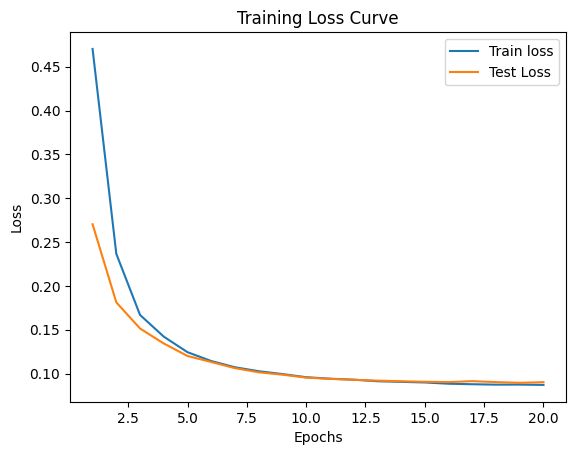

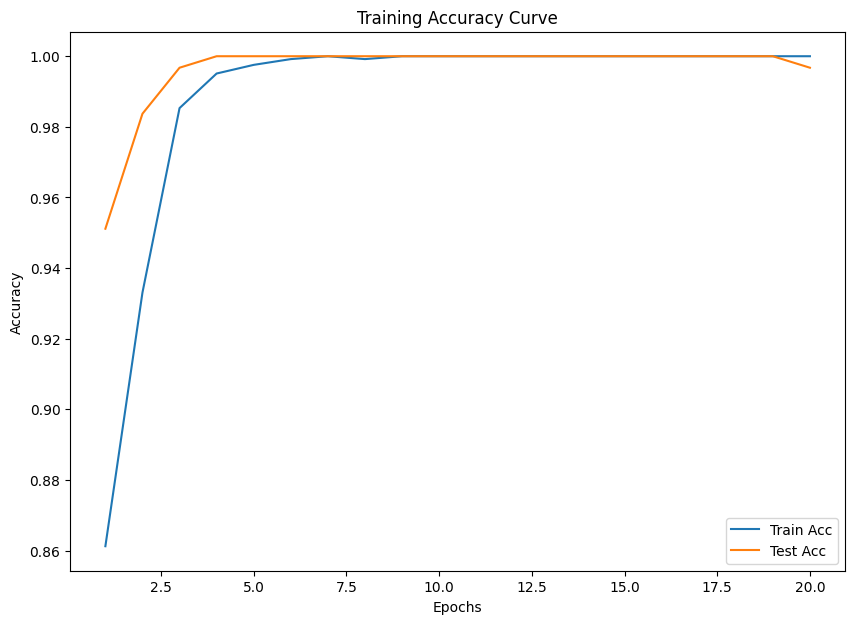

In [134]:
plot_curves(history_ali)

1/1 [==============================] - 0s 312ms/step


(array([[0.9879654]], dtype=float32), array([1.]))

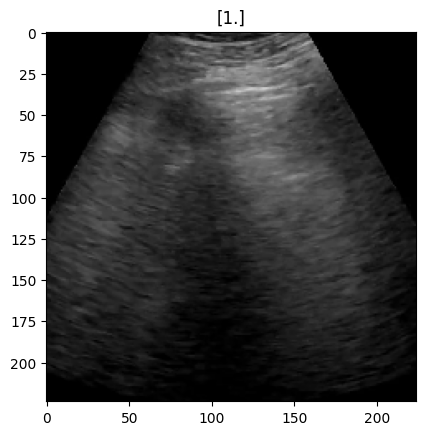

In [135]:
teste = X_test[1]
teste
plt.imshow(teste)
plt.title(str(y_test[1]));

np.expand_dims(teste,0).shape
preds = model_ali.predict(np.expand_dims(teste,0))
preds, y_test[1]

 # Binary: Pleural Irregularities

In [136]:
metadata['Pleural_line_irregularities'].value_counts()

0.0    293
1.0     53
Name: Pleural_line_irregularities, dtype: int64

In [137]:
def create_mydataset_pli():
    X_train, y_train = [], []
    for filename in videos_list:
        count=0
        #print(filename)
        vid_cap = cv2.VideoCapture(path+'/'+filename)
        total_frame_count= int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = total_frame_count/num_imgs_per_video
        success, image = vid_cap.read()
        metadata_cap = metadata.loc[metadata.Filename == filename.split('.')[0]]
        if len(metadata_cap) >0:
            while success:
                #print("Reading new frame...", success)
                if ((count+1) % int(step) == 0):
                    #print("Writing new frame...")
                    out = 'dataset/{}_{}.png'.format(filename.split('.')[0], count)
                    img = tf.keras.utils.load_img(out, target_size = (224, 224, 3))
                    img = tf.keras.utils.img_to_array(img)
                    img= img/255.
                    #img = img.transpose(2,0,1)
                    #cv2.imwrite(out, image)
                    X_train.append(img)
                    y_train.append([metadata['Pleural_line_irregularities'][metadata_cap.index[0]]])
                                     #metadata['Consolidations'][metadata_cap.index[0]],
                                     #metadata['B-lines'][metadata_cap.index[0]],
                                     #metadata['A-lines'][metadata_cap.index[0]],
                                     #metadata['Pleural_line_irregularities'][metadata_cap.index[0]],
                                     #metadata['Air_bronchogram'][metadata_cap.index[0]]])
                success, image = vid_cap.read()
                count += 1
    X = np.array(X_train)
    y = np.array(y_train)
    return X, y

In [138]:
X, y = create_mydataset_pli()
len(X)

1532

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.2)
X_train.shape

(1225, 224, 224, 3)

In [140]:
N_LABELS = 1
EPOCHS = 20
model_pli = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])
model_pli.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss='binary_crossentropy',
  metrics=['accuracy'])
history_pli = model_pli.fit(X_train, y_train,
  epochs=EPOCHS,
  batch_size=64,
  validation_data=(X_test, y_test))

Epoch 1/20
20/20 [==============================] - 64s 3s/step - loss: 0.6799 - accuracy: 0.6694 - val_loss: 0.4292 - val_accuracy: 0.8730
Epoch 2/20
20/20 [==============================] - 59s 3s/step - loss: 0.3545 - accuracy: 0.8906 - val_loss: 0.3221 - val_accuracy: 0.9088
Epoch 3/20
20/20 [==============================] - 60s 3s/step - loss: 0.2738 - accuracy: 0.9265 - val_loss: 0.2741 - val_accuracy: 0.9218
Epoch 4/20
20/20 [==============================] - 59s 3s/step - loss: 0.2305 - accuracy: 0.9469 - val_loss: 0.2432 - val_accuracy: 0.9414
Epoch 5/20
20/20 [==============================] - 59s 3s/step - loss: 0.2020 - accuracy: 0.9673 - val_loss: 0.2159 - val_accuracy: 0.9674
Epoch 6/20
20/20 [==============================] - 59s 3s/step - loss: 0.1768 - accuracy: 0.9820 - val_loss: 0.1963 - val_accuracy: 0.9707
Epoch 7/20
20/20 [==============================] - 59s 3s/step - loss: 0.1615 - accuracy: 0.9845 - val_loss: 0.1809 - val_accuracy: 0.9837
Epoch 8/20
20/20 [==

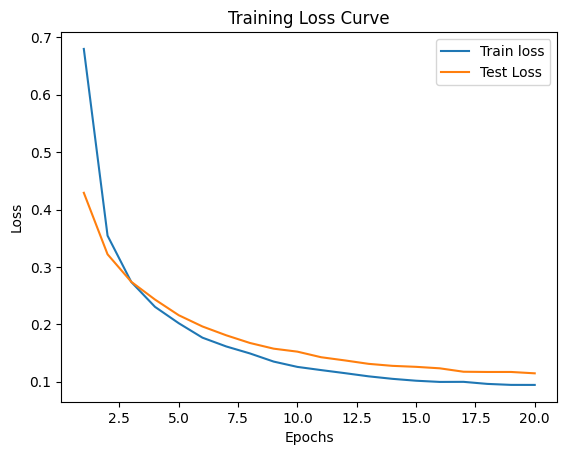

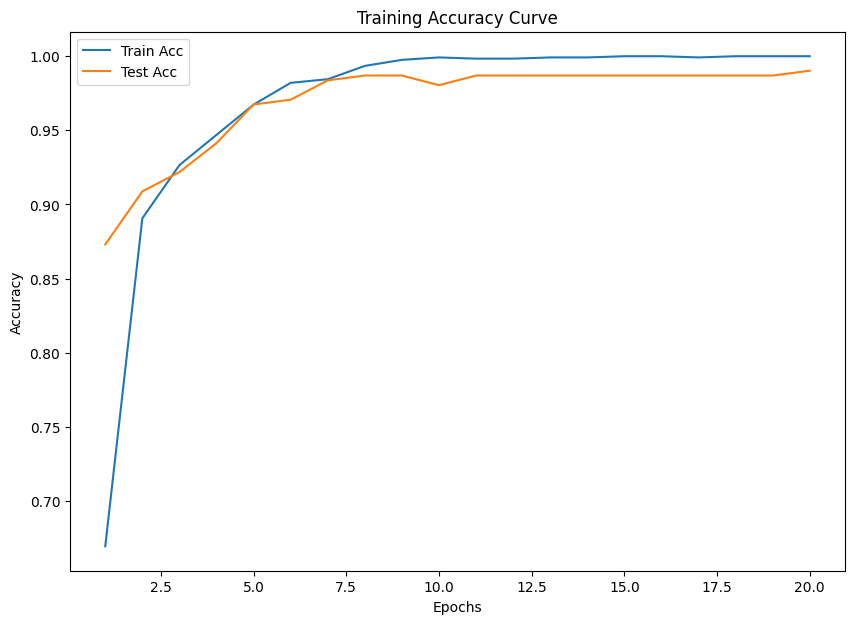

In [141]:
plot_curves(history_pli)

1/1 [==============================] - 0s 366ms/step


(array([[0.00889216]], dtype=float32), array([0.]))

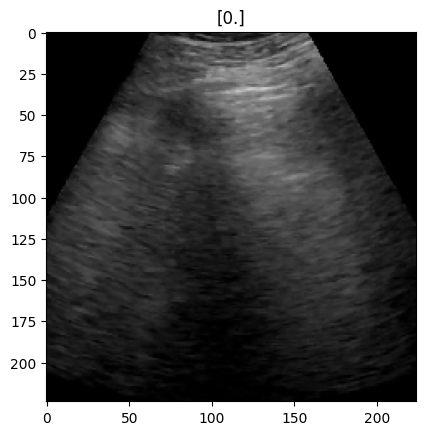

In [142]:
teste = X_test[1]
teste
plt.imshow(teste)
plt.title(str(y_test[1]));

np.expand_dims(teste,0).shape
preds = model_pli.predict(np.expand_dims(teste,0))
preds, y_test[1]

 # Binary: Air_bronchogram

In [143]:
metadata['Air_bronchogram'].value_counts()

0.0    344
1.0      2
Name: Air_bronchogram, dtype: int64

In [148]:
def create_mydataset_air():
    X_train, y_train = [], []
    for filename in videos_list:
        count=0
        #print(filename)
        vid_cap = cv2.VideoCapture(path+'/'+filename)
        total_frame_count= int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = total_frame_count/num_imgs_per_video
        success, image = vid_cap.read()
        metadata_cap = metadata.loc[metadata.Filename == filename.split('.')[0]]
        if len(metadata_cap) >0:
            while success:
                #print("Reading new frame...", success)
                if ((count+1) % int(step) == 0):
                    #print("Writing new frame...")
                    out = 'dataset/{}_{}.png'.format(filename.split('.')[0], count)
                    img = tf.keras.utils.load_img(out, target_size = (224, 224, 3))
                    img = tf.keras.utils.img_to_array(img)
                    img= img/255.
                    #img = img.transpose(2,0,1)
                    #cv2.imwrite(out, image)
                    X_train.append(img)
                    y_train.append([metadata['Air_bronchogram'][metadata_cap.index[0]]])
                                     #metadata['Consolidations'][metadata_cap.index[0]],
                                     #metadata['B-lines'][metadata_cap.index[0]],
                                     #metadata['A-lines'][metadata_cap.index[0]],
                                     #metadata['Pleural_line_irregularities'][metadata_cap.index[0]],
                                     #metadata['Air_bronchogram'][metadata_cap.index[0]]])
                success, image = vid_cap.read()
                count += 1
    X = np.array(X_train)
    y = np.array(y_train)
    return X, y

In [149]:
X, y = create_mydataset_air()
len(X)

1532

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.2)
X_train.shape

(1225, 224, 224, 3)

In [151]:
N_LABELS = 1
EPOCHS = 20
model_air = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])
model_air.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss='binary_crossentropy',
  metrics=['accuracy'])
history_air = model_air.fit(X_train, y_train,
  epochs=EPOCHS,
  batch_size=64,
  validation_data=(X_test, y_test))

Epoch 1/20
20/20 [==============================] - 62s 3s/step - loss: 0.4607 - accuracy: 0.8914 - val_loss: 0.2222 - val_accuracy: 1.0000
Epoch 2/20
20/20 [==============================] - 57s 3s/step - loss: 0.1546 - accuracy: 1.0000 - val_loss: 0.1299 - val_accuracy: 1.0000
Epoch 3/20
20/20 [==============================] - 59s 3s/step - loss: 0.1130 - accuracy: 1.0000 - val_loss: 0.1099 - val_accuracy: 1.0000
Epoch 4/20
20/20 [==============================] - 56s 3s/step - loss: 0.1021 - accuracy: 1.0000 - val_loss: 0.1019 - val_accuracy: 1.0000
Epoch 5/20
20/20 [==============================] - 58s 3s/step - loss: 0.0969 - accuracy: 1.0000 - val_loss: 0.0973 - val_accuracy: 1.0000
Epoch 6/20
20/20 [==============================] - 57s 3s/step - loss: 0.0938 - accuracy: 1.0000 - val_loss: 0.0943 - val_accuracy: 1.0000
Epoch 7/20
20/20 [==============================] - 55s 3s/step - loss: 0.0916 - accuracy: 1.0000 - val_loss: 0.0921 - val_accuracy: 1.0000
Epoch 8/20
20/20 [==

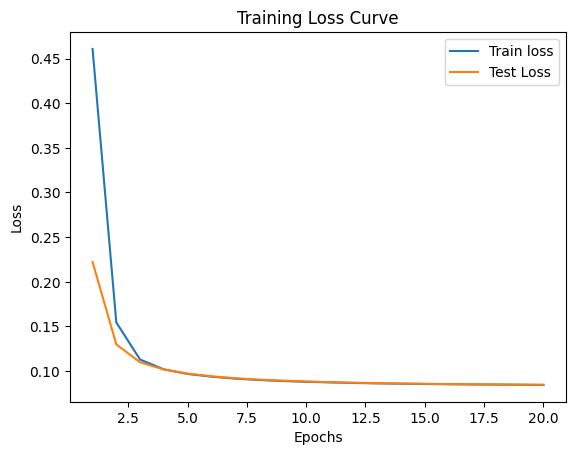

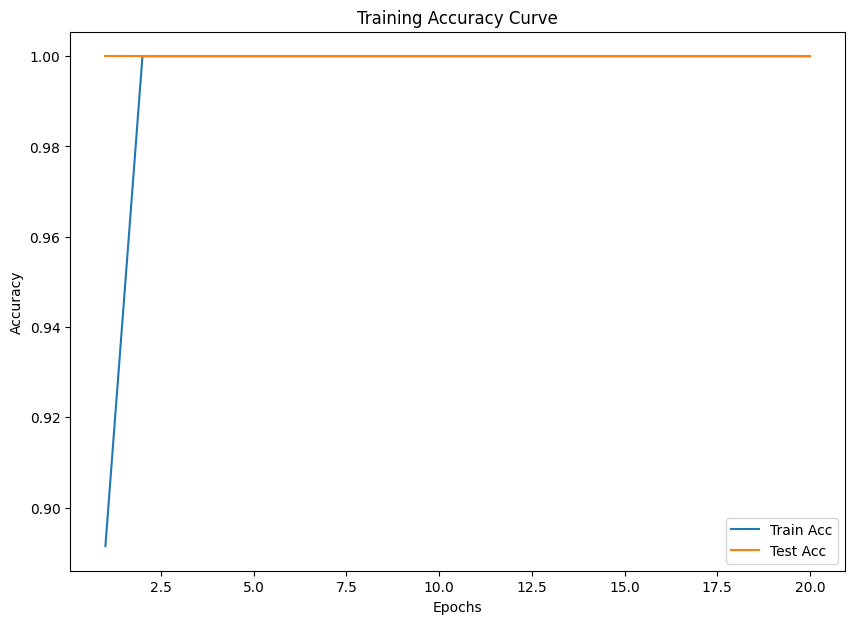

In [152]:
plot_curves(history_air)

1/1 [==============================] - 0s 272ms/step


(array([[0.00445957]], dtype=float32), array([0.]))

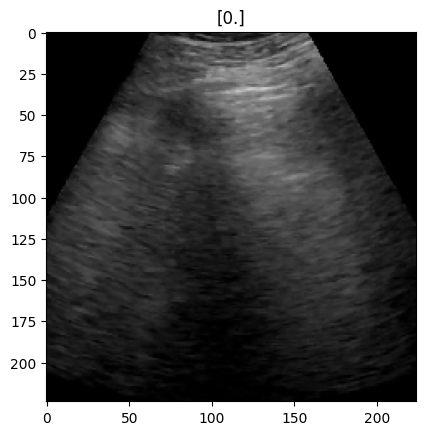

In [153]:
teste = X_test[1]
teste
plt.imshow(teste)
plt.title(str(y_test[1]));

np.expand_dims(teste,0).shape
preds = model_air.predict(np.expand_dims(teste,0))
preds, y_test[1]

# Multilabel  Classification B-lines and A-lines

In [161]:
def create_mydataset_ali_bli():
    X_train, y_train = [], []
    for filename in videos_list:
        count=0
        #print(filename)
        vid_cap = cv2.VideoCapture(path+'/'+filename)
        total_frame_count= int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = total_frame_count/num_imgs_per_video
        success, image = vid_cap.read()
        metadata_cap = metadata.loc[metadata.Filename == filename.split('.')[0]]
        if len(metadata_cap) >0:
            while success:
                #print("Reading new frame...", success)
                if ((count+1) % int(step) == 0):
                    #print("Writing new frame...")
                    out = 'dataset/{}_{}.png'.format(filename.split('.')[0], count)
                    img = tf.keras.utils.load_img(out, target_size = (224, 224, 3))
                    img = tf.keras.utils.img_to_array(img)
                    img= img/255.
                    #img = img.transpose(2,0,1)
                    #cv2.imwrite(out, image)
                    X_train.append(img)
                    y_train.append([metadata['A-lines'][metadata_cap.index[0]],
                                   metadata['B-lines'][metadata_cap.index[0]]])
                                     #metadata['Consolidations'][metadata_cap.index[0]],
                                     #metadata['B-lines'][metadata_cap.index[0]],
                        
                                     #metadata['Pleural_line_irregularities'][metadata_cap.index[0]],
                                     #metadata['Air_bronchogram'][metadata_cap.index[0]]])
                success, image = vid_cap.read()
                count += 1
    X = np.array(X_train)
    y = np.array(y_train)
    return X, y

In [156]:
X, y = create_mydataset_ali_bli()

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.2, shuffle=True)
X_train.shape

(1225, 224, 224, 3)

In [180]:
N_LABELS = 2
EPOCHS = 20
LR = 0.0001
#>1024->512->64->2 = 69, 85
#>1024>512->16->2  = 78, 91
#>1024>512->8->2  = 96, 100
model_a_b = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer_1'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu', name='hidden_layers_2'),
    layers.Dropout(0.2),
    layers.Dense(8, activation='relu', name='hidden_layers_6'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])
model_a_b.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss='binary_crossentropy',
  metrics=['accuracy'])
history_a_b = model_a_b.fit(X_train, y_train,
  epochs=EPOCHS,
  batch_size=64,
  validation_data=(X_test, y_test))

Epoch 1/20
20/20 [==============================] - 65s 3s/step - loss: 0.4096 - accuracy: 0.9673 - val_loss: 0.1259 - val_accuracy: 1.0000
Epoch 2/20
20/20 [==============================] - 57s 3s/step - loss: 0.1036 - accuracy: 0.9984 - val_loss: 0.0825 - val_accuracy: 1.0000
Epoch 3/20
20/20 [==============================] - 57s 3s/step - loss: 0.0835 - accuracy: 0.9657 - val_loss: 0.0813 - val_accuracy: 1.0000
Epoch 4/20
20/20 [==============================] - 57s 3s/step - loss: 0.0820 - accuracy: 0.9437 - val_loss: 0.0811 - val_accuracy: 1.0000
Epoch 5/20
20/20 [==============================] - 56s 3s/step - loss: 0.0815 - accuracy: 0.9518 - val_loss: 0.0809 - val_accuracy: 1.0000
Epoch 6/20
20/20 [==============================] - 57s 3s/step - loss: 0.0812 - accuracy: 0.9445 - val_loss: 0.0807 - val_accuracy: 1.0000
Epoch 7/20
20/20 [==============================] - 56s 3s/step - loss: 0.0809 - accuracy: 0.9298 - val_loss: 0.0813 - val_accuracy: 0.9967
Epoch 8/20
20/20 [==

In [181]:
model_a_b.evaluate(X_test, y_test)

10/10 [==============================] - 3s 260ms/step - loss: 0.0808 - accuracy: 0.9805


[0.08083547651767731, 0.9804560542106628]

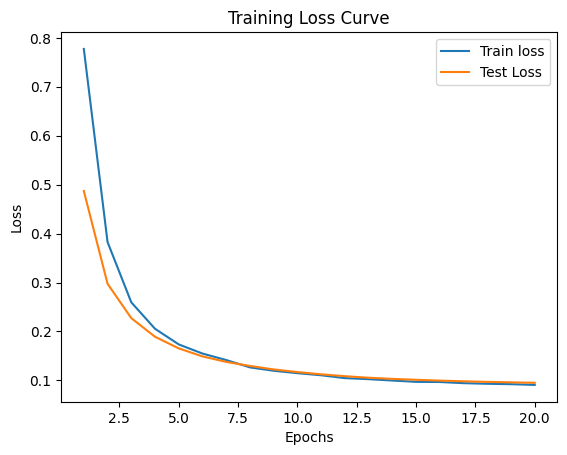

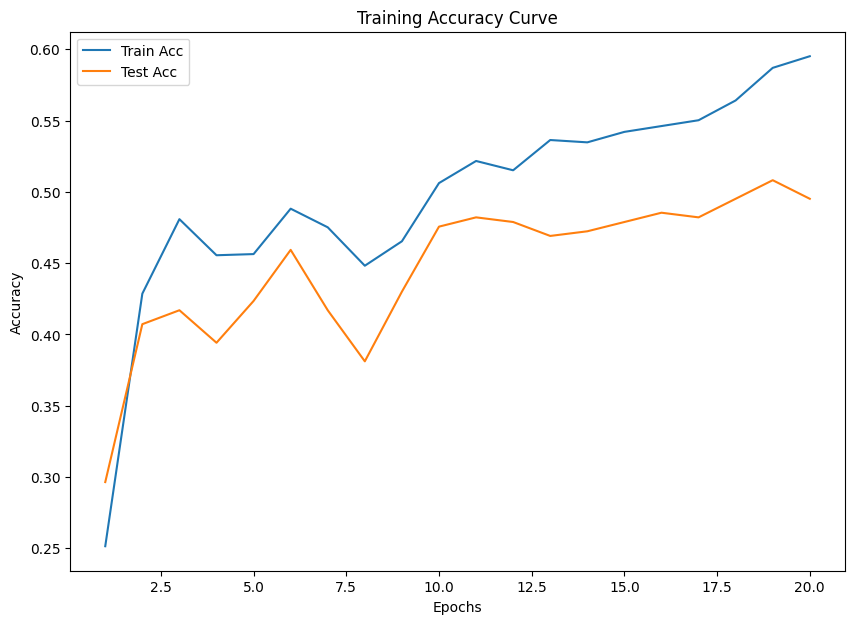

In [159]:
plot_curves(history_air)

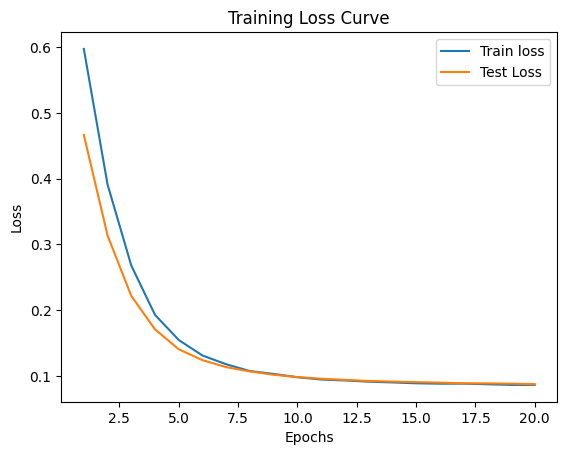

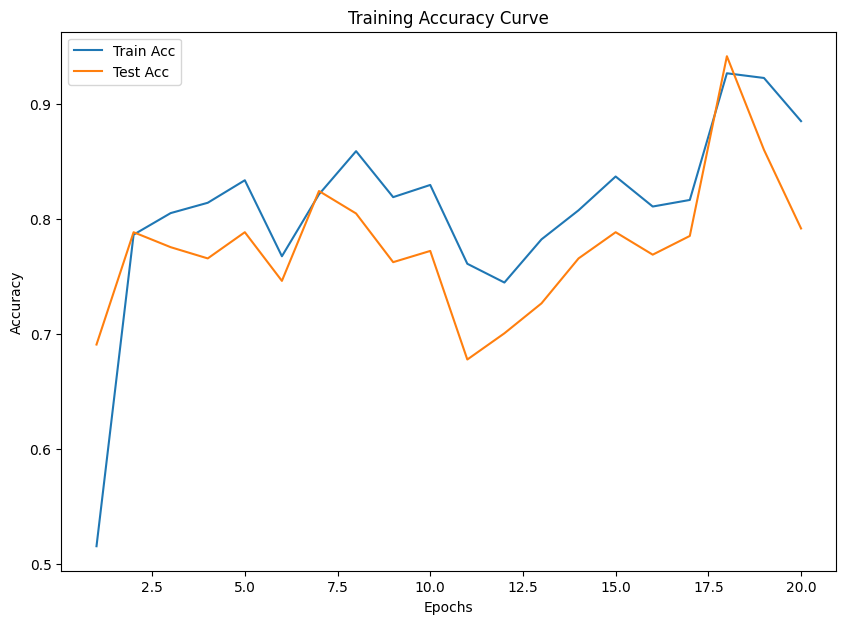

In [163]:
plot_curves(history_a_b)

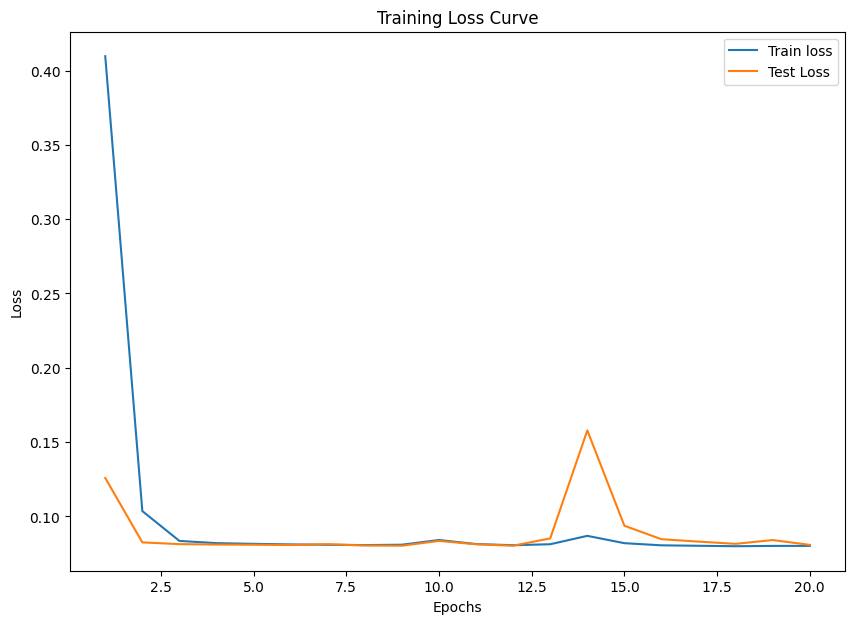

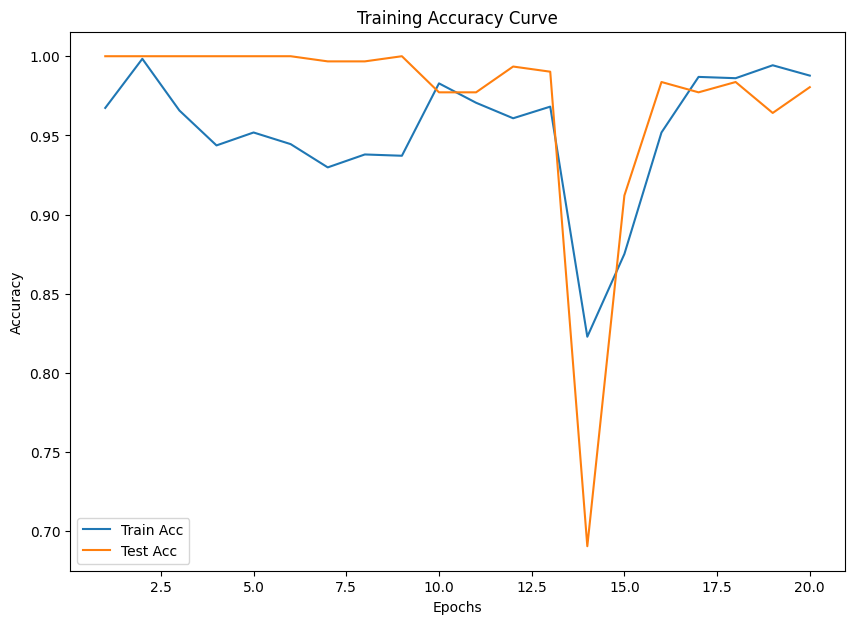

In [184]:
plot_curves(history_a_b)

1/1 [==============================] - 0s 47ms/step


(array([[0.9946881 , 0.03954062]], dtype=float32), array([1., 0.]))

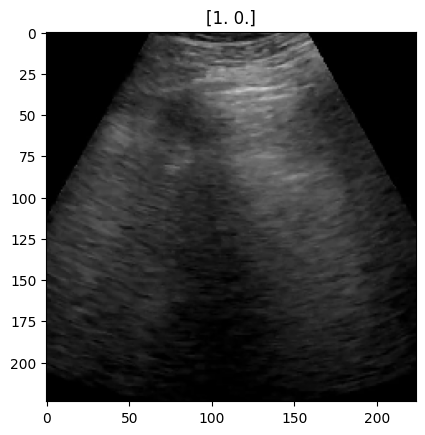

In [185]:
teste = X_test[1]
teste
plt.imshow(teste)
plt.title(str(y_test[1]));

np.expand_dims(teste,0).shape
preds = model_air.predict(np.expand_dims(teste,0))
preds, y_test[1]

  # Multilabel classification? A-line, B-line and Effusion

In [1]:
def create_mydataset_ali_bli_eff():
    X_train, y_train = [], []
    for filename in videos_list:
        count=0
        #print(filename)
        vid_cap = cv2.VideoCapture(path+'/'+filename)
        total_frame_count= int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = total_frame_count/num_imgs_per_video
        success, image = vid_cap.read()
        metadata_cap = metadata.loc[metadata.Filename == filename.split('.')[0]]
        if len(metadata_cap) >0:
            while success:
                #print("Reading new frame...", success)
                if ((count+1) % int(step) == 0):
                    #print("Writing new frame...")
                    out = 'dataset/{}_{}.png'.format(filename.split('.')[0], count)
                    img = tf.keras.utils.load_img(out, target_size = (224, 224, 3))
                    img = tf.keras.utils.img_to_array(img)
                    img= img/255.
                    #img = img.transpose(2,0,1)
                    #cv2.imwrite(out, image)
                    X_train.append(img)
                    y_train.append([metadata['A-lines'][metadata_cap.index[0]],
                                    metadata['B-lines'][metadata_cap.index[0]],
                                    metadata['Effusion'][metadata_cap.index[0]]])
                                     #metadata['Effusion'][metadata_cap.index[0]],
                        
                                     #metadata['Pleural_line_irregularities'][metadata_cap.index[0]],
                                     #metadata['Air_bronchogram'][metadata_cap.index[0]]])
                success, image = vid_cap.read()
                count += 1
    X = np.array(X_train)
    y = np.array(y_train)
    return X, y

In [15]:
X, y = create_mydataset_ali_bli_eff()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.2, shuffle=True)
X_train.shape, y_train.shape

((1225, 224, 224, 3), (1225, 3))

In [18]:
N_LABELS = 3
EPOCHS = 20
LR = 0.0001
#>1024->512->64->2 = 69, 85
#>1024>512->16->2  = 78, 91
#>1024>512->8->2  = 96, 100
model_a_b_f = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer_1'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu', name='hidden_layers_2'),
    layers.Dropout(0.2),
    layers.Dense(8, activation='relu', name='hidden_layers_6'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])
model_a_b_f.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss='binary_crossentropy',
  metrics=['accuracy'])
history_a_b_f = model_a_b_f.fit(X_train, y_train,
  epochs=EPOCHS,
  batch_size=64,
  validation_data=(X_test, y_test))

Epoch 1/20
20/20 [==============================] - 60s 3s/step - loss: 0.5513 - accuracy: 0.7078 - val_loss: 0.6455 - val_accuracy: 0.6710
Epoch 2/20
20/20 [==============================] - 53s 3s/step - loss: 0.3633 - accuracy: 0.8735 - val_loss: 0.6889 - val_accuracy: 0.7492
Epoch 3/20
20/20 [==============================] - 53s 3s/step - loss: 0.2811 - accuracy: 0.9208 - val_loss: 0.6261 - val_accuracy: 0.7883
Epoch 4/20
20/20 [==============================] - 53s 3s/step - loss: 0.2419 - accuracy: 0.9290 - val_loss: 0.7110 - val_accuracy: 0.7850
Epoch 5/20
20/20 [==============================] - 53s 3s/step - loss: 0.2051 - accuracy: 0.9812 - val_loss: 0.5747 - val_accuracy: 0.7850
Epoch 6/20
20/20 [==============================] - 54s 3s/step - loss: 0.1709 - accuracy: 0.9616 - val_loss: 0.6821 - val_accuracy: 0.7948
Epoch 7/20
20/20 [==============================] - 56s 3s/step - loss: 0.1228 - accuracy: 0.9796 - val_loss: 0.3975 - val_accuracy: 0.8176
Epoch 8/20
20/20 [==

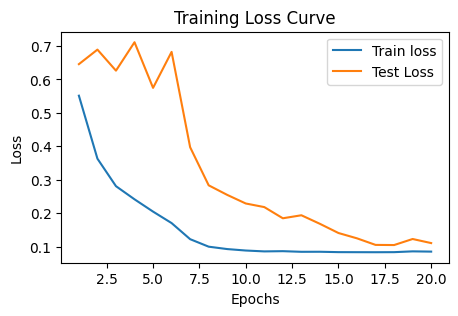

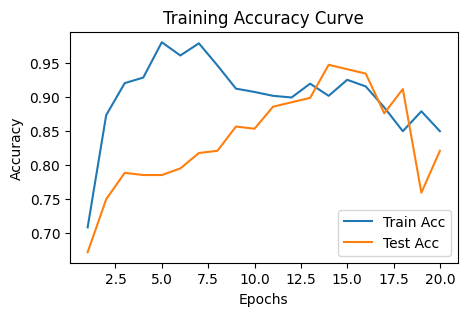

In [23]:
plot_curves(history_a_b_f)

1/1 [==============================] - 0s 307ms/step


(array([[7.471335e-01, 2.728142e-04, 1.783740e-04]], dtype=float32),
 array([1., 0., 0.]))

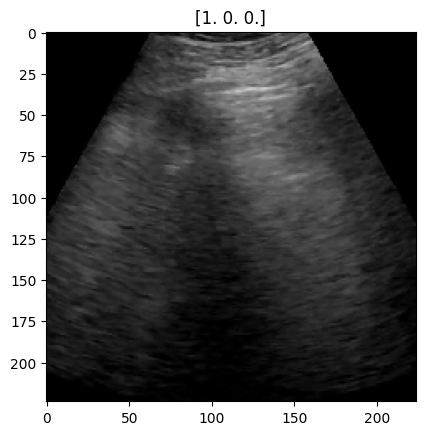

In [25]:
teste = X_test[1]
teste
plt.imshow(teste)
plt.title(str(y_test[1]));

np.expand_dims(teste,0).shape
preds = model_a_b_f.predict(np.expand_dims(teste,0))
preds, y_test[1]

# Multilabel classification: A-line, B-line, Effusion and Consolidations

In [26]:
def create_mydataset_ali_bli_eff_con():
    X_train, y_train = [], []
    for filename in videos_list:
        count=0
        #print(filename)
        vid_cap = cv2.VideoCapture(path+'/'+filename)
        total_frame_count= int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = total_frame_count/num_imgs_per_video
        success, image = vid_cap.read()
        metadata_cap = metadata.loc[metadata.Filename == filename.split('.')[0]]
        if len(metadata_cap) >0:
            while success:
                #print("Reading new frame...", success)
                if ((count+1) % int(step) == 0):
                    #print("Writing new frame...")
                    out = 'dataset/{}_{}.png'.format(filename.split('.')[0], count)
                    img = tf.keras.utils.load_img(out, target_size = (224, 224, 3))
                    img = tf.keras.utils.img_to_array(img)
                    img= img/255.
                    #img = img.transpose(2,0,1)
                    #cv2.imwrite(out, image)
                    X_train.append(img)
                    y_train.append([metadata['A-lines'][metadata_cap.index[0]],
                                    metadata['B-lines'][metadata_cap.index[0]],
                                    metadata['Effusion'][metadata_cap.index[0]],
                                    metadata['Consolidations'][metadata_cap.index[0]]])
                        
                                     #metadata['Pleural_line_irregularities'][metadata_cap.index[0]],
                                     #metadata['Air_bronchogram'][metadata_cap.index[0]]])
                success, image = vid_cap.read()
                count += 1
    X = np.array(X_train)
    y = np.array(y_train)
    return X, y

In [27]:
X, y = create_mydataset_ali_bli_eff_con()

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.2, shuffle=True)
X_train.shape, y_train.shape

((1225, 224, 224, 3), (1225, 4))

In [29]:
N_LABELS = 4
EPOCHS = 20
LR = 0.0001
#>1024->512->64->2 = 69, 85
#>1024>512->16->2  = 78, 91
#>1024>512->8->2  = 96, 100
model_a_b_f_c = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer_1'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu', name='hidden_layers_2'),
    layers.Dropout(0.2),
    layers.Dense(8, activation='relu', name='hidden_layers_6'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])
model_a_b_f_c.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss='binary_crossentropy',
  metrics=['accuracy'])
history_a_b_f_c = model_a_b_f_c.fit(X_train, y_train,
  epochs=EPOCHS,
  batch_size=64,
  validation_data=(X_test, y_test))

Epoch 1/20
20/20 [==============================] - 60s 3s/step - loss: 0.3917 - accuracy: 0.6441 - val_loss: 0.1999 - val_accuracy: 0.7134
Epoch 2/20
20/20 [==============================] - 54s 3s/step - loss: 0.1562 - accuracy: 0.7224 - val_loss: 0.1439 - val_accuracy: 0.8502
Epoch 3/20
20/20 [==============================] - 53s 3s/step - loss: 0.1167 - accuracy: 0.7282 - val_loss: 0.1139 - val_accuracy: 0.8469
Epoch 4/20
20/20 [==============================] - 53s 3s/step - loss: 0.1002 - accuracy: 0.7363 - val_loss: 0.1029 - val_accuracy: 0.7980
Epoch 5/20
20/20 [==============================] - 53s 3s/step - loss: 0.0918 - accuracy: 0.7510 - val_loss: 0.0950 - val_accuracy: 0.8339
Epoch 6/20
20/20 [==============================] - 54s 3s/step - loss: 0.0884 - accuracy: 0.7771 - val_loss: 0.0914 - val_accuracy: 0.8143
Epoch 7/20
20/20 [==============================] - 55s 3s/step - loss: 0.0888 - accuracy: 0.7861 - val_loss: 0.0886 - val_accuracy: 0.7818
Epoch 8/20
20/20 [==

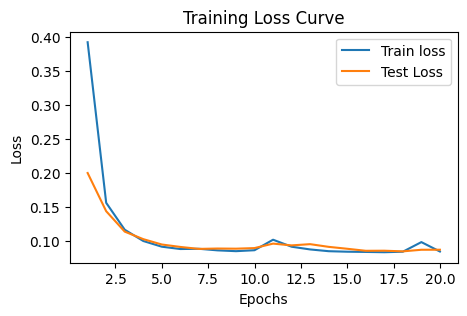

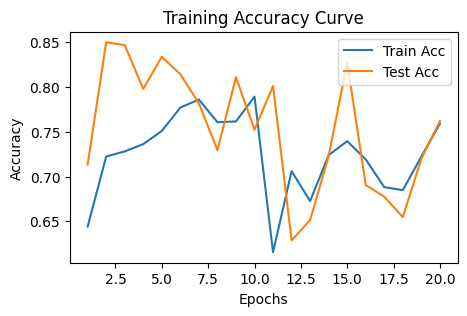

In [30]:
plot_curves(history_a_b_f_c)

# Multilabel classification: A-line, B-line, Effusion, Consolidations and Pleural irregularities

In [31]:
def create_mydataset_all():
    X_train, y_train = [], []
    for filename in videos_list:
        count=0
        #print(filename)
        vid_cap = cv2.VideoCapture(path+'/'+filename)
        total_frame_count= int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = total_frame_count/num_imgs_per_video
        success, image = vid_cap.read()
        metadata_cap = metadata.loc[metadata.Filename == filename.split('.')[0]]
        if len(metadata_cap) >0:
            while success:
                #print("Reading new frame...", success)
                if ((count+1) % int(step) == 0):
                    #print("Writing new frame...")
                    out = 'dataset/{}_{}.png'.format(filename.split('.')[0], count)
                    img = tf.keras.utils.load_img(out, target_size = (224, 224, 3))
                    img = tf.keras.utils.img_to_array(img)
                    img= img/255.
                    #img = img.transpose(2,0,1)
                    #cv2.imwrite(out, image)
                    X_train.append(img)
                    y_train.append([metadata['A-lines'][metadata_cap.index[0]],
                                    metadata['B-lines'][metadata_cap.index[0]],
                                    metadata['Effusion'][metadata_cap.index[0]],
                                    metadata['Consolidations'][metadata_cap.index[0]],
                                    metadata['Pleural_line_irregularities'][metadata_cap.index[0]]])
                                     #metadata['Air_bronchogram'][metadata_cap.index[0]]])
                success, image = vid_cap.read()
                count += 1
    X = np.array(X_train)
    y = np.array(y_train)
    return X, y

In [32]:
X, y = create_mydataset_all()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.2, shuffle=True)
X_train.shape, y_train.shape

((1225, 224, 224, 3), (1225, 5))

In [35]:
N_LABELS = 5
EPOCHS = 20
LR = 0.0001
#>1024->512->64->2 = 69, 85
#>1024>512->16->2  = 78, 91
#>1024>512->8->2  = 96, 100
model_a_b_f_c = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer_1'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu', name='hidden_layers_2'),
    layers.Dropout(0.2),
    layers.Dense(8, activation='relu', name='hidden_layers_6'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])
model_a_b_f_c.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss='binary_crossentropy',
  metrics=['accuracy'])
history_a_b_f_c = model_a_b_f_c.fit(X_train, y_train,
  epochs=EPOCHS,
  batch_size=64,
  validation_data=(X_test, y_test))

Epoch 1/20
20/20 [==============================] - 59s 3s/step - loss: 0.4721 - accuracy: 0.4759 - val_loss: 0.2376 - val_accuracy: 0.4984
Epoch 2/20
20/20 [==============================] - 53s 3s/step - loss: 0.2009 - accuracy: 0.5412 - val_loss: 0.1504 - val_accuracy: 0.4984
Epoch 3/20
20/20 [==============================] - 53s 3s/step - loss: 0.1426 - accuracy: 0.5445 - val_loss: 0.1256 - val_accuracy: 0.5472
Epoch 4/20
20/20 [==============================] - 56s 3s/step - loss: 0.1206 - accuracy: 0.6229 - val_loss: 0.1162 - val_accuracy: 0.5505
Epoch 5/20
20/20 [==============================] - 54s 3s/step - loss: 0.1119 - accuracy: 0.6098 - val_loss: 0.1096 - val_accuracy: 0.5375
Epoch 6/20
20/20 [==============================] - 58s 3s/step - loss: 0.1069 - accuracy: 0.5943 - val_loss: 0.1107 - val_accuracy: 0.5277
Epoch 7/20
20/20 [==============================] - 60s 3s/step - loss: 0.1062 - accuracy: 0.6188 - val_loss: 0.1061 - val_accuracy: 0.5635
Epoch 8/20
20/20 [==

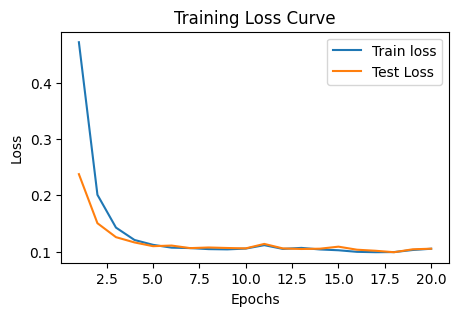

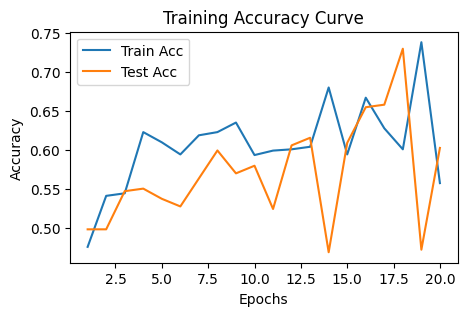

In [36]:
plot_curves(history_a_b_f_c)

In [44]:
N_LABELS = 5
EPOCHS = 20
LR = 0.0001
#>1024->512->5 = 68, 72
#>1024->256->5 = 63, 73
#>1024->128->5 = 63, 67
#>1024->64->5 = ----
#>1024->32->5 = 63, 67
#>1024->512->32->5 = 55, 56
#>1024>512->16->5  = 54, 56
#>1024>512->8->5  = 73, 72
model_all = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer_1'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu', name='hidden_layers_2'),
    layers.Dropout(0.2),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])
model_all.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss='binary_crossentropy',
  metrics=['accuracy'])
history_all = model_all.fit(X_train, y_train,
  epochs=EPOCHS,
  batch_size=64,
  validation_data=(X_test, y_test))

Epoch 1/20
20/20 [==============================] - 63s 3s/step - loss: 0.3027 - accuracy: 0.3878 - val_loss: 0.0945 - val_accuracy: 0.3746
Epoch 2/20
20/20 [==============================] - 55s 3s/step - loss: 0.1187 - accuracy: 0.4784 - val_loss: 0.0804 - val_accuracy: 0.4202
Epoch 3/20
20/20 [==============================] - 55s 3s/step - loss: 0.1028 - accuracy: 0.5102 - val_loss: 0.0787 - val_accuracy: 0.5179
Epoch 4/20
20/20 [==============================] - 56s 3s/step - loss: 0.0948 - accuracy: 0.4890 - val_loss: 0.0788 - val_accuracy: 0.5147
Epoch 5/20
20/20 [==============================] - 55s 3s/step - loss: 0.0997 - accuracy: 0.4914 - val_loss: 0.0768 - val_accuracy: 0.5212
Epoch 6/20
20/20 [==============================] - 55s 3s/step - loss: 0.0927 - accuracy: 0.5020 - val_loss: 0.0772 - val_accuracy: 0.5375
Epoch 7/20
20/20 [==============================] - 55s 3s/step - loss: 0.0893 - accuracy: 0.5061 - val_loss: 0.0804 - val_accuracy: 0.5244
Epoch 8/20
20/20 [==

In [45]:
N_LABELS = 5
EPOCHS = 20
LR = 0.0001
#>1024->512->5 = 68, 72
#>1024->256->5 = 63, 73
#>1024->128->5 = 63, 67
#>1024->64->5 = ----
#>1024->32->5 = 63, 67
#>1024->512->32->5 = 55, 56
#>1024>512->16->5  = 54, 56
#>1024>512->8->5  = 73, 72
model_all = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer_1'),
    layers.Dropout(0.2),
    layers.Dense(25, activation='relu', name='hidden_layers_2'),
    layers.Dropout(0.2),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])
model_all.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss='binary_crossentropy',
  metrics=['accuracy'])
history_all = model_all.fit(X_train, y_train,
  epochs=EPOCHS,
  batch_size=64,
  validation_data=(X_test, y_test))

Epoch 1/20
20/20 [==============================] - 61s 3s/step - loss: 0.4223 - accuracy: 0.4367 - val_loss: 0.1418 - val_accuracy: 0.3876
Epoch 2/20
20/20 [==============================] - 56s 3s/step - loss: 0.1940 - accuracy: 0.4971 - val_loss: 0.0915 - val_accuracy: 0.3779
Epoch 3/20
20/20 [==============================] - 56s 3s/step - loss: 0.1580 - accuracy: 0.4833 - val_loss: 0.0839 - val_accuracy: 0.3909
Epoch 4/20
20/20 [==============================] - 56s 3s/step - loss: 0.1359 - accuracy: 0.4800 - val_loss: 0.0805 - val_accuracy: 0.3779
Epoch 5/20
20/20 [==============================] - 56s 3s/step - loss: 0.1403 - accuracy: 0.4751 - val_loss: 0.0837 - val_accuracy: 0.3876
Epoch 6/20
20/20 [==============================] - 56s 3s/step - loss: 0.1302 - accuracy: 0.4767 - val_loss: 0.0815 - val_accuracy: 0.4039
Epoch 7/20
20/20 [==============================] - 56s 3s/step - loss: 0.1193 - accuracy: 0.4833 - val_loss: 0.0792 - val_accuracy: 0.4365
Epoch 8/20
20/20 [==

In [46]:
N_LABELS = 5
EPOCHS = 20
LR = 0.0001
#>1024->512->5 = 68, 72
#>1024->256->5 = 63, 73
#>1024->128->5 = 63, 67
#>1024->64->5 = ----
#>1024->32->5 = 63, 67
#>1024->512->32->5 = 55, 56
#>1024>512->16->5  = 54, 56
#>1024>512->8->5  = 73, 72
model_all = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer_1'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='relu', name='hidden_layers_2'),
    layers.Dropout(0.2),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])
model_all.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss='binary_crossentropy',
  metrics=['accuracy'])
history_all = model_all.fit(X_train, y_train,
  epochs=EPOCHS,
  batch_size=64,
  validation_data=(X_test, y_test))

Epoch 1/20
20/20 [==============================] - 63s 3s/step - loss: 0.6954 - accuracy: 0.4645 - val_loss: 0.5449 - val_accuracy: 0.8730
Epoch 2/20
20/20 [==============================] - 56s 3s/step - loss: 0.5895 - accuracy: 0.5935 - val_loss: 0.4788 - val_accuracy: 0.8795
Epoch 3/20
20/20 [==============================] - 56s 3s/step - loss: 0.5381 - accuracy: 0.6286 - val_loss: 0.3852 - val_accuracy: 0.8860
Epoch 4/20
20/20 [==============================] - 57s 3s/step - loss: 0.5169 - accuracy: 0.5820 - val_loss: 0.3644 - val_accuracy: 0.8534
Epoch 5/20
20/20 [==============================] - 56s 3s/step - loss: 0.4905 - accuracy: 0.6114 - val_loss: 0.3415 - val_accuracy: 0.8795
Epoch 6/20
20/20 [==============================] - 57s 3s/step - loss: 0.4768 - accuracy: 0.6335 - val_loss: 0.3255 - val_accuracy: 0.8795
Epoch 7/20
20/20 [==============================] - 57s 3s/step - loss: 0.4813 - accuracy: 0.6139 - val_loss: 0.3178 - val_accuracy: 0.8013
Epoch 8/20
20/20 [==

In [48]:
N_LABELS = 5
EPOCHS = 20
LR = 0.0001
#>1024->512->5 = 68, 72
#>1024->256->5 = 63, 73
#>1024->128->5 = 63, 67
#>1024->64->5 = ----
#>1024->32->5 = 63, 67
#>1024->512->32->5 = 55, 56
#>1024>512->16->5  = 54, 56
#>1024>512->8->5  = 73, 72
model_all = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer_1'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu', name='hidden_layers_2'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='relu', name='hidden_layers_3'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])
model_all.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss='binary_crossentropy',
  metrics=['accuracy'])
history_all = model_all.fit(X_train, y_train,
  epochs=EPOCHS,
  batch_size=64,
  validation_data=(X_test, y_test))

Epoch 1/20
20/20 [==============================] - 75s 3s/step - loss: 0.5959 - accuracy: 0.7584 - val_loss: 0.5203 - val_accuracy: 0.8371
Epoch 2/20
20/20 [==============================] - 67s 3s/step - loss: 0.5020 - accuracy: 0.8751 - val_loss: 0.5055 - val_accuracy: 0.8502
Epoch 3/20
20/20 [==============================] - 67s 3s/step - loss: 0.4891 - accuracy: 0.8759 - val_loss: 0.4975 - val_accuracy: 0.8567
Epoch 4/20
20/20 [==============================] - 67s 3s/step - loss: 0.4835 - accuracy: 0.8816 - val_loss: 0.4915 - val_accuracy: 0.8306
Epoch 5/20
20/20 [==============================] - 69s 3s/step - loss: 0.4789 - accuracy: 0.8824 - val_loss: 0.4859 - val_accuracy: 0.8371
Epoch 6/20
20/20 [==============================] - 68s 3s/step - loss: 0.4731 - accuracy: 0.8890 - val_loss: 0.4813 - val_accuracy: 0.8176
Epoch 7/20
20/20 [==============================] - 68s 3s/step - loss: 0.4679 - accuracy: 0.8833 - val_loss: 0.4774 - val_accuracy: 0.8339
Epoch 8/20
20/20 [==

In [49]:
N_LABELS = 5
EPOCHS = 20
LR = 0.0001
#>1024->512->5 = 68, 72
#>1024->256->5 = 63, 73
#>1024->128->5 = 63, 67
#>1024->64->5 = ----
#>1024->32->5 = 63, 67
#>1024->512->32->5 = 55, 56
#>1024>512->16->5  = 54, 56
#>1024>512->8->5  = 73, 72
model_all = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer_1'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu', name='hidden_layers_2'),
    layers.Dropout(0.2),
    layers.Dense(20, activation='relu', name='hidden_layers_3'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])
model_all.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss='binary_crossentropy',
  metrics=['accuracy'])
history_all = model_all.fit(X_train, y_train,
  epochs=EPOCHS,
  batch_size=64,
  validation_data=(X_test, y_test))

Epoch 1/20
20/20 [==============================] - 73s 3s/step - loss: 0.4028 - accuracy: 0.5706 - val_loss: 0.1839 - val_accuracy: 0.7948
Epoch 2/20
20/20 [==============================] - 68s 3s/step - loss: 0.1233 - accuracy: 0.5714 - val_loss: 0.0909 - val_accuracy: 0.4788
Epoch 3/20
20/20 [==============================] - 69s 3s/step - loss: 0.0800 - accuracy: 0.5576 - val_loss: 0.0773 - val_accuracy: 0.4886
Epoch 4/20
20/20 [==============================] - 71s 4s/step - loss: 0.0741 - accuracy: 0.5788 - val_loss: 0.0748 - val_accuracy: 0.7427
Epoch 5/20
20/20 [==============================] - 67s 3s/step - loss: 0.0738 - accuracy: 0.6033 - val_loss: 0.0757 - val_accuracy: 0.8371
Epoch 6/20
20/20 [==============================] - 70s 3s/step - loss: 0.0727 - accuracy: 0.6465 - val_loss: 0.0754 - val_accuracy: 0.8958
Epoch 7/20
20/20 [==============================] - 70s 3s/step - loss: 0.0731 - accuracy: 0.7731 - val_loss: 0.0755 - val_accuracy: 0.8534
Epoch 8/20
20/20 [==

In [51]:
N_LABELS = 5
EPOCHS = 20
LR = 0.0001
#>1024->512->5 = 68, 72
#>1024->256->5 = 63, 73
#>1024->128->5 = 63, 67
#>1024->64->5 = ----
#>1024->32->5 = 63, 67
#>1024->512->32->5 = 55, 56
#>1024>512->16->5  = 54, 56
#>1024>512->8->5  = 73, 72
model_all = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer_1'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='relu', name='hidden_layers_2'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='relu', name='hidden_layers_3'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])
model_all.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss='binary_crossentropy',
  metrics=['accuracy'])
history_all = model_all.fit(X_train, y_train,
  epochs=EPOCHS,
  batch_size=64,
  validation_data=(X_test, y_test))

Epoch 1/20
20/20 [==============================] - 76s 4s/step - loss: 0.6925 - accuracy: 0.3045 - val_loss: 0.5505 - val_accuracy: 0.3844
Epoch 2/20
20/20 [==============================] - 70s 4s/step - loss: 0.5885 - accuracy: 0.3437 - val_loss: 0.4921 - val_accuracy: 0.4202
Epoch 3/20
20/20 [==============================] - 69s 3s/step - loss: 0.5567 - accuracy: 0.3551 - val_loss: 0.4549 - val_accuracy: 0.3420
Epoch 4/20
20/20 [==============================] - 72s 4s/step - loss: 0.5330 - accuracy: 0.3404 - val_loss: 0.4473 - val_accuracy: 0.3876
Epoch 5/20
20/20 [==============================] - 69s 3s/step - loss: 0.5184 - accuracy: 0.3584 - val_loss: 0.4213 - val_accuracy: 0.3909
Epoch 6/20
20/20 [==============================] - 69s 3s/step - loss: 0.4956 - accuracy: 0.3788 - val_loss: 0.4070 - val_accuracy: 0.3876
Epoch 7/20
20/20 [==============================] - 70s 4s/step - loss: 0.4914 - accuracy: 0.3396 - val_loss: 0.4031 - val_accuracy: 0.3941
Epoch 8/20
20/20 [==

In [52]:
N_LABELS = 5
EPOCHS = 20
LR = 0.0001
#>1024->512->5 = 68, 72
#>1024->256->5 = 63, 73
#>1024->128->5 = 63, 67
#>1024->64->5 = ----
#>1024->32->5 = 63, 67
#>1024->512->32->5 = 55, 56
#>1024>512->16->5  = 54, 56
#>1024>512->8->5  = 73, 72
model_all = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer_1'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu', name='hidden_layers_2'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='relu', name='hidden_layers_3'),
    layers.Dense(10, activation='relu', name='hidden_layers_4'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])
model_all.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss='binary_crossentropy',
  metrics=['accuracy'])
history_all = model_all.fit(X_train, y_train,
  epochs=EPOCHS,
  batch_size=64,
  validation_data=(X_test, y_test))

Epoch 1/20
20/20 [==============================] - 74s 3s/step - loss: 0.3813 - accuracy: 0.4049 - val_loss: 0.2485 - val_accuracy: 0.3746
Epoch 2/20
20/20 [==============================] - 67s 3s/step - loss: 0.1997 - accuracy: 0.5045 - val_loss: 0.1873 - val_accuracy: 0.4267
Epoch 3/20
20/20 [==============================] - 73s 4s/step - loss: 0.1518 - accuracy: 0.4931 - val_loss: 0.1471 - val_accuracy: 0.4463
Epoch 4/20
20/20 [==============================] - 70s 3s/step - loss: 0.1224 - accuracy: 0.5110 - val_loss: 0.1286 - val_accuracy: 0.4560
Epoch 5/20
20/20 [==============================] - 68s 3s/step - loss: 0.1099 - accuracy: 0.4931 - val_loss: 0.1146 - val_accuracy: 0.4495
Epoch 6/20
20/20 [==============================] - 68s 3s/step - loss: 0.1003 - accuracy: 0.4988 - val_loss: 0.1008 - val_accuracy: 0.4495
Epoch 7/20
20/20 [==============================] - 68s 3s/step - loss: 0.0915 - accuracy: 0.5118 - val_loss: 0.0913 - val_accuracy: 0.4495
Epoch 8/20
20/20 [==

In [53]:
N_LABELS = 5
EPOCHS = 20
LR = 0.0001
#>1024->512->5 = 68, 72
#>1024->256->5 = 63, 73
#>1024->128->5 = 63, 67
#>1024->64->5 = ----
#>1024->32->5 = 63, 67
#>1024->512->32->5 = 55, 56
#>1024>512->16->5  = 54, 56
#>1024>512->8->5  = 73, 72
model_all = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer_1'),
    layers.Dropout(0.2),
    layers.Dense(20, activation='relu', name='hidden_layers_2'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='relu', name='hidden_layers_3'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])
model_all.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss='binary_crossentropy',
  metrics=['accuracy'])
history_all = model_all.fit(X_train, y_train,
  epochs=EPOCHS,
  batch_size=64,
  validation_data=(X_test, y_test))

Epoch 1/20
20/20 [==============================] - 77s 4s/step - loss: 0.5174 - accuracy: 0.3592 - val_loss: 0.2743 - val_accuracy: 0.4267
Epoch 2/20
20/20 [==============================] - 68s 3s/step - loss: 0.2884 - accuracy: 0.5159 - val_loss: 0.1749 - val_accuracy: 0.4560
Epoch 3/20
20/20 [==============================] - 67s 3s/step - loss: 0.2424 - accuracy: 0.4833 - val_loss: 0.1590 - val_accuracy: 0.4365
Epoch 4/20
20/20 [==============================] - 67s 3s/step - loss: 0.2262 - accuracy: 0.5273 - val_loss: 0.1509 - val_accuracy: 0.7720
Epoch 5/20
20/20 [==============================] - 68s 3s/step - loss: 0.2114 - accuracy: 0.5355 - val_loss: 0.1449 - val_accuracy: 0.8241
Epoch 6/20
20/20 [==============================] - 67s 3s/step - loss: 0.1978 - accuracy: 0.6024 - val_loss: 0.1348 - val_accuracy: 0.8306
Epoch 7/20
20/20 [==============================] - 67s 3s/step - loss: 0.1967 - accuracy: 0.5527 - val_loss: 0.1360 - val_accuracy: 0.8274
Epoch 8/20
20/20 [==

1/1 [==============================] - 0s 45ms/step


(array([[ True, False, False, False, False]]), array([1., 0., 0., 0., 0.]))

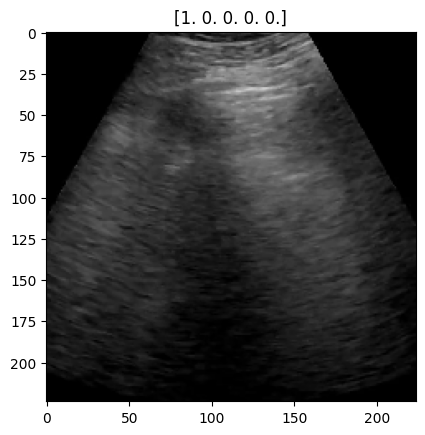

In [55]:
teste = X_test[1]
teste
plt.imshow(teste)
plt.title(str(y_test[1]));

np.expand_dims(teste,0).shape
preds = model_all.predict(np.expand_dims(teste,0))
preds = np.array(preds> 0.5)
preds, y_test[1]

In [65]:
preds, preds.squeeze().shape

(array([[ True, False, False, False, False]]), (5,))

In [62]:
#evaluate
from sklearn.metrics import confusion_matrix, accuracy_score
classe_test = np.array(y_test[1])
print(classe_test.shape)
acc = accuracy_score(classe_test, preds)
acc

(5,)


ValueError: Found input variables with inconsistent numbers of samples: [5, 1]

In [ ]:
matriz = confusion_matrix(classe_test, preds)
matriz